# Model Based Machine Learning Project

The following is the code we used to write the report. 

The section are the following:

* Data processing and display
* Linear models and Neural Network
* Hierarchical model
* Temporal model

### Preprocess data

This notebook contains all the code for preprocessing the data of LE and it's factors. 

"DataSetReconstruct.csv" is all the data where we have used outside sources to reconstruct the data as much as possible. At this point we have a total of 2936 rows and 22 column, but only 1859 of the rows have no NaN values.

This notebook imputes missing values and ends up saving the data as "Data_processed.csv". This data has all 2936 rows and 22 columns NaN free. 

In [1]:
# First the necessary imports

import numpy as np # linear algebra
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # data processing
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns
import pyro
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')


C:\Users\Magnus\anaconda3\envs\pyro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this part we replace the NaN values with the closest value in time for that country.
Meaning that for example if Denmark has no value for Health expenditure in 2005, we will replace it with the value from 2004. If there is no value for 2004, we will replace it with the value from 2006. If no value for 2006, go to 2003 etc...

In [2]:

data = pd.read_csv("Data/DataSetReconstruct.csv", sep=';')

# log transform GDP, Population and MeaslesPrMillion as these are skewed, + 1 to avoid log(0)
data['GDP'] = np.log(data['GDP'] + 1)
data['Population'] = np.log(data['Population'] + 1)
data['MeaslesPrMillion'] = np.log(data['MeaslesPrMillion'] + 1)
# print total amount of nan values in entire dataset
print(data.isnull().sum().sum())

# Now we will replace the missing values with the closest year of missing value of that country
for col in data.columns:
    if col == 'Country' or col == 'Year':
        continue
    # check if column is numerical
    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        # replace missing values with closest year of missing value of that country
        for country in data['Country'].unique():
            d = data[data['Country'] == country]
            # check if there are missing values
            if d[col].isnull().sum() > 0:
                # get index of missing values
                idx = d[d[col].isnull()].index.values
                # loop over all missing values
                for i in idx:
                    # get year of missing value by indexing on the row index
                    year = data['Year'].loc[i] 
                    # get index of closest year
                    list_of_closest_years = (d['Year'] - year).abs().argsort()[::-1]

                    for new_year in list_of_closest_years.index:
                        new_data = d[col].loc[new_year]
                        # overwrite missing value with closest year
                        if np.isnan(new_data):
                            continue
                        data[col][i] = new_data
                        break

2205


Finally, we replace values that are still NaN with the mean of that column.
This happens only if there is no value for that country in any year.

In [3]:
# replace remaining nan values by mean of column
for col in data.columns:
    if col == 'Country' or col == 'Year':
        continue
    # check if column is numerical
    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        # replace missing values with mean of column
        data[col] = data[col].fillna(data[col].mean())


# only keep relevant columns
# We throw away columns that we don't care about
data = data[['Country', 'continent', 'Life expectancy ', 'Year', 'Status', 'infant deaths', 'Alcohol', 'Hepatitis B', 'MeaslesPrMillion', 'OverweightOfAdults%', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', 'Schooling', 'WaterFacility', 'WomenInParlament']]

# save data
data.to_csv('Data/Data_processed.csv', sep=';', index=False)

Now it's all set and done as we have a dataset with no NaN values. Time to go Pyro!

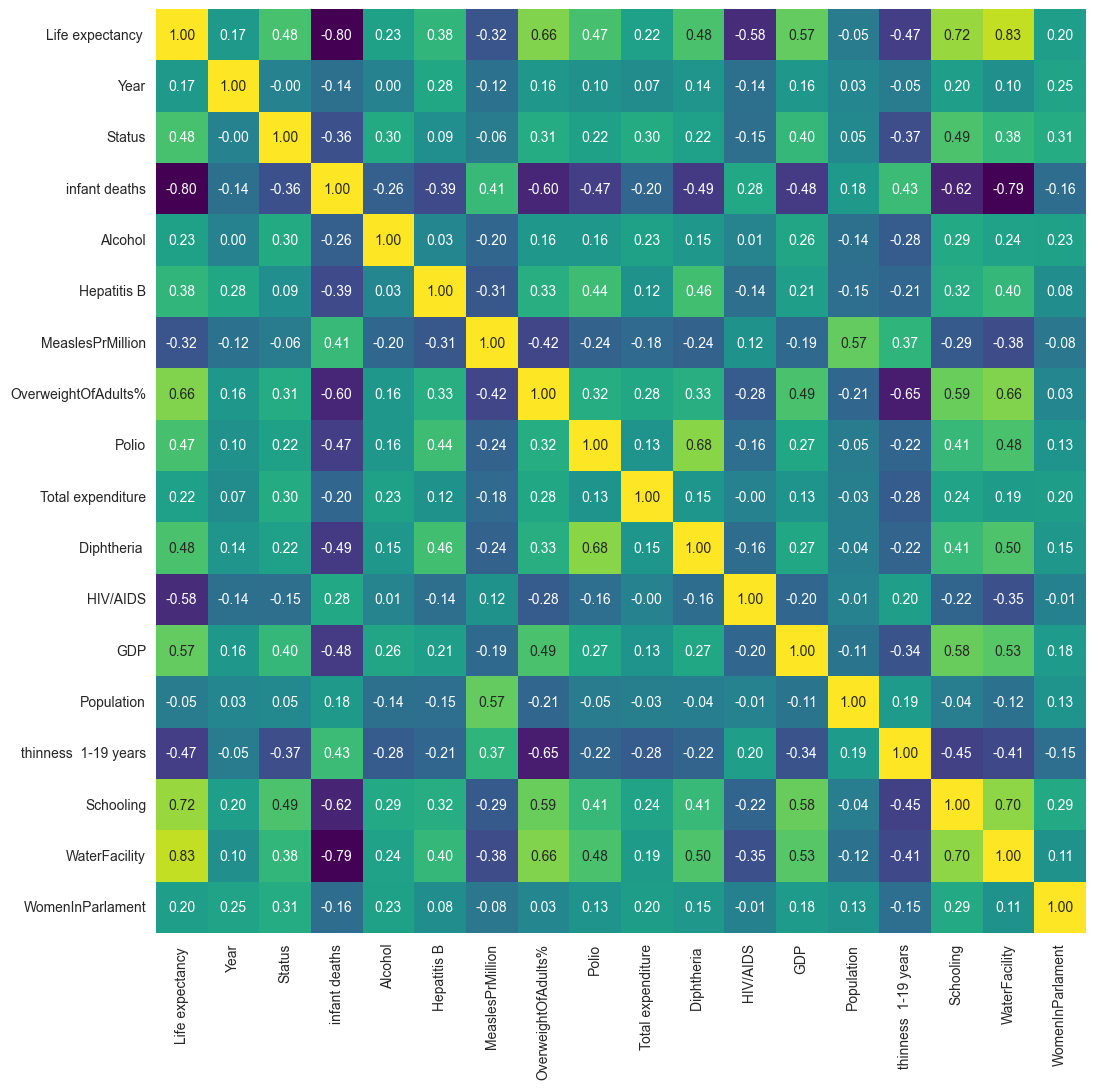

In [4]:
# Load data
path = "Data/Data_processed.csv"
LED = pd.read_csv(path,delimiter=";")

# Compute the correlation matrix
corr_matrix = LED.corr()

plt.figure(figsize=(12, 12))

# Plot the correlation matrix using seaborn heatmap
sns.heatmap(corr_matrix, cmap='viridis', annot=True, fmt=".2f", cbar=False)
#plt.title('Correlation Plot of Dataframe')

plt.savefig("CorrMatrix.eps",format="eps")

plt.show()

.

.

# Linear and non-linear global models

This section of the notebook contains code for training the global (non-hierachical) models.

It is split into 4 parts:
1) Baseline linear regression
2) Bayesian linear regression
3) Neural network
4) Combining Neural network and Baysian linear regression

In all parts the respective models are trained and then evaluated on the three datasets (training, test and validation).

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive

In [6]:
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
torch.manual_seed(0)

# Load data
path = "Data/Data_processed.csv"
data = pd.read_csv(path,delimiter=";")

In [7]:
# Define helper function for data split
def standardize_and_split(X,y):

    # Split data into traning, test and validation
    training_idx = (data['Year'] >= 2000) & (data['Year'] <= 2011)
    test_idx = (data['Year'] >= 2012) & (data['Year'] <= 2013)
    val_idx = (data['Year'] >= 2014) & (data['Year'] <= 2015)

    X_train = X[training_idx,:]
    X_test = X[test_idx,:]
    X_val = X[val_idx, :]

    # Standardize input features
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)
    X_train = (X_train - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std

    # Split data 
    y_train = y[training_idx]
    y_test = y[test_idx]
    y_val = y[val_idx]

    # Standardize target
    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train = (y_train - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std
    y_val = (y_val - y_mean) / y_std

    return X_train, X_test, X_val, y_train, y_test, y_val, y_mean, y_std

In [8]:
mat = data.values

# Convert data to numpy 
features = data.columns.to_list()[5:]
X_numpy = np.array(mat[:,5:],float)
y_numpy = np.array(mat[:,2],float) 

# Split and standardize data and save training mean and std for later when evaluating predictions
X_train, X_test, X_val, y_train, y_test, y_val, y_mean, y_std  = standardize_and_split(X_numpy,y_numpy)

In [9]:
# Define function for training standard linear regression
def train_linear_regression(X_train,y_train,features):

    # Setup standard linear regression model without fitting an intercept
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(X_train, y_train)

    # Print coefficients
    for c, f in zip(regr.coef_,features):
        print("Feature: {} = {}".format(f,round(c,3)))
        
    return regr



# Define function for evaluating standard linear regression
def compute_rmse(preds_train,preds_test,preds_val, y_train, y_test, y_val, y_std, y_mean):

    # Convert back to the original scale
    y_true_train = y_train * y_std + y_mean
    y_true_test = y_test * y_std + y_mean
    y_true_val = y_val * y_std + y_mean

    # Compute RMSE
    def rmse(predicted,trues):
        rmse = np.sqrt(np.mean((predicted - trues)**2))
        return rmse
    
    # Evaluate on all splits
    rmse_train = rmse(y_true_train, preds_train)
    rmse_test = rmse(y_true_test, preds_test)
    rmse_val = rmse(y_true_val, preds_val)

    # Show and return results
    print("RMSE train: %.3f\nRMSE test: %.3f\nRMSE val: %.3f\n" % (rmse_train,rmse_test,rmse_val))
    return rmse_train, rmse_test, rmse_val
          

def eval_regression(regr,y_train, y_test, y_val,y_std,y_mean):

    # Predict on all splits
    y_hat_train = regr.predict(X_train)*y_std+y_mean
    y_hat_test = regr.predict(X_test)*y_std+y_mean
    y_hat_val = regr.predict(X_val)*y_std+y_mean

    # Return RMSE for all splits
    return compute_rmse(y_hat_train,y_hat_test,y_hat_val,y_train,y_test,y_val,y_std,y_mean)

In [10]:
# Train and evaluate linear regression model
regr = train_linear_regression(X_train,y_train,features)
rmse_train, rmse_test, rmse_val = eval_regression(regr,y_train, y_test, y_val,y_std,y_mean)

Feature: infant deaths = -0.313
Feature: Alcohol = -0.008
Feature: Hepatitis B = 0.008
Feature: MeaslesPrMillion = 0.04
Feature: OverweightOfAdults% = 0.064
Feature: Polio = 0.015
Feature: Total expenditure = 0.024
Feature: Diphtheria  = 0.016
Feature:  HIV/AIDS = -0.345
Feature: GDP = 0.08
Feature: Population = 0.034
Feature:  thinness  1-19 years = -0.022
Feature: Schooling = 0.153
Feature: WaterFacility = 0.26
Feature: WomenInParlament = 0.039
RMSE train: 3.097
RMSE test: 3.438
RMSE val: 3.344



## Bayesian linear regression with Pyro

In [11]:
# Define function for doing Bayesian linear regression with Pyro
def bayesian_regression(X_train,y_train,features):

    def model(X, obs=None):
        beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                                torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
        sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))   # Prior for the variance
        
        with pyro.plate("data"):
            y = pyro.sample("y", dist.Normal(X.matmul(beta), sigma), obs=obs)
            
        return y

    # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 5000

    # Setup the optimizer
    adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
    optimizer = ClippedAdam(adam_params)

    X_train_torch = torch.tensor(X_train).float()
    y_train_torch = torch.tensor(y_train).float()
   
    pyro.clear_param_store()

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_torch, y_train_torch)
        if step % 100 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

    # Do Bayesian inference
    predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta", "sigma"))
    samples = predictive(X_train_torch, y_train_torch)
    beta_samples = samples["beta"].detach().numpy()
    betas = beta_samples.mean(axis=0)

    # Print coefficients alongside CI intervals
    for i, (c, f) in enumerate(zip(betas[0,:],features)):
        ci_lower = np.percentile(beta_samples[:,0,i], (100 - 90) / 2)
        ci_upper = np.percentile(beta_samples[:,0,i], 100 - (100 - 90) / 2)
        print("Feature: {} = {} [{};{}]".format(f,round(c,2),round(ci_lower,2),round(ci_upper,2)))

    return beta_samples

In [12]:
# Define function for evaluation of bayesian regression
def eval_bayesian(beta_samples,X_train,X_test,X_val,y_train, y_test, y_val,y_std,y_mean):

    # Predict on all splits
    y_hat_train =  np.mean(np.dot(X_train, beta_samples[:,0].T), axis=1)*y_std+y_mean
    y_hat_test = np.mean(np.dot(X_test, beta_samples[:,0].T), axis=1)*y_std+y_mean
    y_hat_val = np.mean(np.dot(X_val, beta_samples[:,0].T), axis=1)*y_std+y_mean

    # Return RMSE for all splits using previous helper function
    return compute_rmse(y_hat_train,y_hat_test,y_hat_val,y_train, y_test, y_val,y_std,y_mean)

In [13]:
# Train and evaluate Baysian linear regression model
beta_samples = bayesian_regression(X_train,y_train,features)
rmse_train_b, rmse_test_b, rmse_val_b = eval_bayesian(beta_samples,X_train,X_test,X_val,y_train, y_test, y_val,y_std,y_mean)

[0] ELBO: 3521.7
[100] ELBO: 3170.6
[200] ELBO: 2832.3
[300] ELBO: 2643.8
[400] ELBO: 2161.2
[500] ELBO: 2292.4
[600] ELBO: 2046.4
[700] ELBO: 1771.2
[800] ELBO: 1453.3
[900] ELBO: 1267.1
[1000] ELBO: 1224.2
[1100] ELBO: 1293.2
[1200] ELBO: 1037.8
[1300] ELBO: 999.8
[1400] ELBO: 1068.2
[1500] ELBO: 988.8
[1600] ELBO: 950.2
[1700] ELBO: 1003.8
[1800] ELBO: 891.4
[1900] ELBO: 952.1
[2000] ELBO: 865.3
[2100] ELBO: 898.5
[2200] ELBO: 826.2
[2300] ELBO: 824.2
[2400] ELBO: 822.8
[2500] ELBO: 883.7
[2600] ELBO: 809.2
[2700] ELBO: 784.3
[2800] ELBO: 947.0
[2900] ELBO: 820.3
[3000] ELBO: 802.3
[3100] ELBO: 777.2
[3200] ELBO: 761.3
[3300] ELBO: 764.3
[3400] ELBO: 771.7
[3500] ELBO: 775.4
[3600] ELBO: 746.4
[3700] ELBO: 758.4
[3800] ELBO: 768.7
[3900] ELBO: 743.8
[4000] ELBO: 764.0
[4100] ELBO: 757.8
[4200] ELBO: 758.8
[4300] ELBO: 750.6
[4400] ELBO: 751.8
[4500] ELBO: 753.7
[4600] ELBO: 753.6
[4700] ELBO: 742.3
[4800] ELBO: 752.0
[4900] ELBO: 749.9
Feature: infant deaths = -0.3100000023841858 [-

## Train Neural network using SVI

In [14]:
# Define Neural network class
class Net(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(Net, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, X_nn, y=None):
        X_nn = self.relu(self.in_layer(X_nn))
        X_nn = self.relu(self.h_layer(X_nn))
        X_nn = self.relu(self.h_layer2(X_nn))
        X_nn = self.out_layer(X_nn)

        prediction_mean = X_nn.squeeze(-1)
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
            
        return y

In [15]:
# Define function for training neural network
def train_neural_network(X_train,y_train, model,linear=False):

    # Convert data to torch
    X_train_torch = torch.tensor(X_train).float()
    y_train_torch = torch.tensor(y_train).float()
    X_test_torch = torch.tensor(X_test).float()
    X_val_torch = torch.tensor(X_val).float()

    # Define guide function
    guide = AutoDiagonalNormal(model)
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = Adam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_torch, y_train_torch)
        if step % 500 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

    # Make predictions for test set
    predictive = Predictive(model, guide=guide, num_samples=1000,
                            return_sites=("obs", "_RETURN"))
    samples_test = predictive(X_test_torch)
    samples_train = predictive(X_train_torch)
    samples_val = predictive(X_val_torch)
    y_pred_train = samples_train["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
    y_pred_test = samples_test["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
    y_pred_val = samples_val["obs"].mean(axis=0).detach().numpy() * y_std + y_mean

    # If using a combined model, sample the linear parameters
    if linear:
        predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
        samples = predictive(X_train_torch, y_train_torch)
        betas = samples["beta"].mean(axis=0).detach().numpy()[0]
        return y_pred_train, y_pred_test, y_pred_val, betas, samples

    return y_pred_train, y_pred_test, y_pred_val

In [16]:
# Initialize and train DNN
net = Net(n_in=X_train.shape[1], n_hidden=32, n_out=1)
y_pred_train, y_pred_test, y_pred_val = train_neural_network(X_train,y_train,net)

# Evaluate DNN with evaluation function 
rmse_train_n, rmse_test_n, rmse_val_n = compute_rmse(y_pred_train,y_pred_test,y_pred_val, y_train, y_test, y_val, y_std, y_mean)

[0] ELBO: 3743157.7
[500] ELBO: 43122.1
[1000] ELBO: 30431.2
[1500] ELBO: 24763.9
[2000] ELBO: 19295.7
[2500] ELBO: 13926.5
[3000] ELBO: 14661.0
[3500] ELBO: 16635.9
[4000] ELBO: 11958.3
[4500] ELBO: 11279.9
[5000] ELBO: 10661.3
[5500] ELBO: 10031.3
[6000] ELBO: 11329.9
[6500] ELBO: 8472.4
[7000] ELBO: 10846.4
[7500] ELBO: 9024.7
[8000] ELBO: 9129.8
[8500] ELBO: 6300.8
[9000] ELBO: 7471.1
[9500] ELBO: 7423.5
[10000] ELBO: 6131.5
[10500] ELBO: 6165.1
[11000] ELBO: 5387.6
[11500] ELBO: 5283.4
[12000] ELBO: 4917.3
[12500] ELBO: 4026.7
[13000] ELBO: 3423.7
[13500] ELBO: 4103.9
[14000] ELBO: 3523.5
[14500] ELBO: 3194.2
[15000] ELBO: 2962.0
[15500] ELBO: 2575.3
[16000] ELBO: 2487.8
[16500] ELBO: 2454.1
[17000] ELBO: 2409.9
[17500] ELBO: 2102.9
[18000] ELBO: 2029.6
[18500] ELBO: 2106.5
[19000] ELBO: 1731.7
[19500] ELBO: 1990.1
RMSE train: 0.824
RMSE test: 1.940
RMSE val: 2.219



## Combining Neural network with Bayesian linear regression

In [17]:
# Define combined model
class FFNet(Net):
    def __init__(self, n_in, n_hidden, n_out, linear_features):
        # Inherit from Net
        super(FFNet, self).__init__(n_in, n_hidden, n_out)
        
        self.linear_features = linear_features
        self.non_linear_features = [i for i in range(15) if not i in(self.linear_features)]

    # Overwrite forward function to include linear parameters
    def forward(self, X, y=None):

        # Pass non-linear features through network
        X_nn = X[:,self.non_linear_features]
        X_nn = self.relu(self.in_layer(X_nn))
        X_nn = self.relu(self.h_layer(X_nn))
        X_nn = self.relu(self.h_layer2(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)
        
        # Do Bayesian regression on linear features
        beta_lin = pyro.sample("beta", dist.Normal(torch.zeros(len(self.linear_features)), 
                                            torch.ones(len(self.linear_features))).to_event(1))
        X_linear = X[:,self.linear_features]

        # Combine outputs
        with pyro.plate("observations"):
            linear_out = X_linear.matmul(beta_lin)
            out = nn_out+linear_out
            y = pyro.sample("obs", dist.Normal(out, 0.1), obs=y)
            
        return y

In [18]:
# Initialize and train our combined model
linear_features_H = [2,3,5,7,8] # Hepatitis B', 'MeaslesPrMillion', 'Polio', 'Diphteria', 'HIV/AIDS'
net_lr = FFNet(n_in=X_train.shape[1]-len(linear_features_H), 
                n_hidden=32, n_out=1,linear_features=linear_features_H)

# Train new model using SVI
y_pred_train2, y_pred_test2, y_pred_val2, betas, samples = train_neural_network(X_train,y_train,net_lr,True)

# Do Bayesian inference to get coefficients and CI intervals
beta_samples2 = samples['beta'].detach().numpy()
for i, (c, f) in enumerate(zip(betas,np.array(features)[linear_features_H])):
    ci_lower = np.percentile(beta_samples2[:,0,i], (100 - 90) / 2)
    ci_upper = np.percentile(beta_samples2[:,0,i], 100 - (100 - 90) / 2)
    print("Feature: {} = {} [{};{}]".format(f,round(c,2),round(ci_lower,2),round(ci_upper,2)))

# Evaluate combined model
rmse_train_nl, rmse_test_nl, rmse_val_nl = compute_rmse(y_pred_train2,y_pred_test2,y_pred_val2, y_train, y_test, y_val, y_std, y_mean)

[0] ELBO: 1259055.2
[500] ELBO: 37442.6
[1000] ELBO: 38620.5
[1500] ELBO: 23099.7
[2000] ELBO: 20817.5
[2500] ELBO: 16827.5
[3000] ELBO: 14821.8
[3500] ELBO: 10221.2
[4000] ELBO: 10004.1
[4500] ELBO: 10241.0
[5000] ELBO: 10741.4
[5500] ELBO: 9350.3
[6000] ELBO: 7675.0
[6500] ELBO: 6374.2
[7000] ELBO: 9994.6
[7500] ELBO: 6737.0
[8000] ELBO: 6984.0
[8500] ELBO: 5414.6
[9000] ELBO: 4492.7
[9500] ELBO: 5063.6
[10000] ELBO: 4762.1
[10500] ELBO: 4932.1
[11000] ELBO: 3478.8
[11500] ELBO: 3143.1
[12000] ELBO: 3217.2
[12500] ELBO: 2907.4
[13000] ELBO: 2680.0
[13500] ELBO: 2974.0
[14000] ELBO: 2777.1
[14500] ELBO: 2047.6
[15000] ELBO: 2020.3
[15500] ELBO: 1974.4
[16000] ELBO: 1817.6
[16500] ELBO: 1471.6
[17000] ELBO: 1486.5
[17500] ELBO: 1459.7
[18000] ELBO: 1569.0
[18500] ELBO: 1458.5
[19000] ELBO: 1190.6
[19500] ELBO: 1203.5
Feature: Hepatitis B = 0.009999999776482582 [0.01;0.02]
Feature: MeaslesPrMillion = 0.0 [-0.0;0.01]
Feature: Polio = -0.0 [-0.0;0.0]
Feature: Diphtheria  = 0.0099999997764

.

.

# Hierarichal model 

We start by importing packages.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import statsmodels.api as sm
import random

#Plotting
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
palette = itertools.cycle(sns.color_palette("tab20", n_colors=20))
import matplotlib.cm as cm

#Machine learning 
from sklearn import linear_model
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)

In [27]:
#Loading the data
data = pd.read_csv("Data/Data_processed_subregions.csv",delimiter=";")
#Formatting into pandas dataframe 
LED = pd.DataFrame(data)

In [28]:
print(LED.info()) #Check quality of data. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                2936 non-null   object 
 1   continent              2936 non-null   object 
 2   subregion              2936 non-null   object 
 3   Life expectancy        2936 non-null   float64
 4   Year                   2936 non-null   int64  
 5   Status                 2936 non-null   int64  
 6   infant deaths          2936 non-null   float64
 7   Alcohol                2936 non-null   float64
 8   Hepatitis B            2936 non-null   float64
 9   MeaslesPrMillion       2936 non-null   float64
 10  OverweightOfAdults%    2936 non-null   float64
 11  Polio                  2936 non-null   int64  
 12  Total expenditure      2936 non-null   float64
 13  Diphtheria             2936 non-null   int64  
 14   HIV/AIDS              2936 non-null   float64
 15  GDP 

In [29]:
## Setting up data for Pyro model

LED.head(5) #Display first 5 row to get idea of the data. 

mat = LED.values #Convert dataframe into matrix 

X = mat[:,6:].astype("float") #These are the regressors
print(X.shape)

y_original = mat[:,3].astype("float") #This is the target variable life expectancy
print(y_original.shape)

#These are the hierarchies
continent = mat[:,1] 
subregion = mat[:,2] 
developed = mat[:,5]
print(continent.shape)

#Setup split for traning, validation and test data set. We will use 2000-2012 as traning and 2013-2015 as test. 
#Remember to add in report: We can not split randomly as then we will feed info to the model I should not have. 
training_idx = (data['Year'] >= 2000) & (data['Year'] <= 2011)
test_idx = (data['Year'] >= 2012) & (data['Year'] <= 2013)
val_idx = (data['Year'] >= 2014) & (data['Year'] <= 2015)

# standardize input features
X_mean = X[training_idx,:].mean(axis=0)
X_std = X[training_idx,:].std(axis=0)
X = (X - X_mean) / X_std

# standardize target
y_mean = y_original[training_idx].mean()
y_std = y_original[training_idx].std()
y = (y_original - y_mean) / y_std

(2936, 15)
(2936,)
(2936,)


In [30]:
def dataSplit(data,trainIDX,testIDX,valIDX): #Define function to split data
    train = data[trainIDX]
    test  = data[testIDX]
    val   = data[valIDX]
    
    return train, test, val

#Split features 
X_train = X[training_idx,:]
X_test = X[test_idx,:]
X_val = X[val_idx, :]

#Split observations
y_train, y_test, y_val = dataSplit(y,training_idx,test_idx,val_idx)

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))
print("num val: %d" % len(y_val))

developed_train, developed_test, developed_val = dataSplit(developed,training_idx,test_idx,val_idx)

num train: 2196
num test: 374
num val: 366


In [31]:
def dataSplit(data,trainIDX,testIDX,valIDX): #Define function to split data
    train = data[trainIDX]
    test  = data[testIDX]
    val   = data[valIDX]
    
    return train, test, val

#Split features 
X_train = X[training_idx,:]
X_test = X[test_idx,:]
X_val = X[val_idx, :]

#Split observations
y_train, y_test, y_val = dataSplit(y,training_idx,test_idx,val_idx)

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))
print("num val: %d" % len(y_val))

developed_train, developed_test, developed_val = dataSplit(developed,training_idx,test_idx,val_idx)

num train: 2196
num test: 374
num val: 366


In [32]:
# Setting up hierarchical dictonaries 

#Contienent dictonaries
continent_dict = {'Asia': 0, 'Europe': 1, 'Africa': 2, 'North America': 3,  'South America': 4, 'Oceania': 5}

#Sub-region dictonaries
subregion_dict = region_dict = {
    'Southern Asia': 0,
    'Southern Europe': 1,
    'Northern Africa': 2,
    'Sub-Saharan Africa': 3,
    'Latin America and the Caribbean': 4,
    'Western Asia': 5,
    'Australia and New Zealand': 6,
    'Western Europe': 7,
    'Eastern Europe': 8,
    'South-eastern Asia': 9,
    'Northern America': 10,
    'Eastern Asia': 11,
    'Northern Europe': 12,
    'Melanesia': 13,
    'Central Asia': 14,
    'Micronesia': 15,
    'Polynesia': 16
}

#Split hierarchical features 
continent_train =  np.array(LED.loc[training_idx, 'continent'].map(continent_dict))
continent_test  =  np.array(LED.loc[test_idx,     'continent'].map(continent_dict))
continent_val   =  np.array(LED.loc[val_idx,      'continent'].map(continent_dict))

subregion_train =  np.array(LED.loc[training_idx, 'subregion'].map(subregion_dict))
subregion_test  =  np.array(LED.loc[test_idx,     'subregion'].map(subregion_dict))
subregion_val   =  np.array(LED.loc[val_idx,      'subregion'].map(subregion_dict))

## Two-level hierarichal model (Report model)

In this section we define the two-level hierarichical model which is presented in the report. Both alpha and beta are on the second level.

In [33]:
def hierarchical_model_TwoLevel_AB(X,continents,developed,num_hir, obs=None):
    n_ind = num_hir
    n_dev = 2
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))        # Hyper-Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(2.)) # Hyper-Prior for the bias standard deviation
    
    beta_mu = pyro.sample("beta_mu", dist.Normal(0., 1.))          # Hyper-Prior for the bias mean
    beta_sigma  = pyro.sample("beta_sigma", dist.HalfCauchy(2.))   # Hyper-Prior for the bias standard deviation

    sigma = pyro.sample("sigma", dist.HalfCauchy(2.))              # Prior for the observation variance

    with pyro.plate("developed", n_ind):
        
        with pyro.plate("continents", n_dev):                      # Drawing parameters for each of the groupings
            alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 
            beta = pyro.sample("beta", dist.Normal(beta_mu*torch.ones(X.shape[1]), 
                                               beta_sigma*torch.ones(X.shape[1])).to_event(1)) 

    with pyro.plate("data"):
        mu = alpha[developed,continents] + torch.sum(torch.mul(X,beta[developed,continents]),dim=1)
        y = pyro.sample("y", dist.Normal(mu,sigma).to_event(), obs=obs)
        
    return y

In [34]:
#Convert to torch tensors for MCMC
developed_train_pyro = torch.tensor(developed_train.astype("long")).long()  
developed_test_pyro = torch.tensor(developed_test.astype("long")).long()
developed_val_pyro = torch.tensor(developed_val.astype("long")).long()

X_train_pyro = torch.tensor(X_train).float()
y_train_pyro = torch.tensor(y_train).float()

subregion_train_pyro = torch.tensor(subregion_train).long()

# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_model_TwoLevel_AB)
mcmcTwoLevel_AB = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcTwoLevel_AB.run(X_train_pyro,subregion_train_pyro,developed_train_pyro,17, y_train_pyro)

# Show summary of inference results
mcmcTwoLevel_AB.summary()

Sample: 100%|██████████| 1200/1200 [16:06,  1.24it/s, step size=5.85e-02, acc. prob=0.857]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha[0,0]      0.33      0.11      0.33      0.14      0.49    634.13      1.00
   alpha[0,1]      0.47      0.13      0.48      0.27      0.69    559.94      1.00
   alpha[0,2]      0.17      0.13      0.17     -0.05      0.38    364.60      1.02
   alpha[0,3]     -0.39      0.03     -0.39     -0.44     -0.34   1031.81      1.00
   alpha[0,4]     -0.05      0.04     -0.05     -0.11      0.03   1104.48      1.00
   alpha[0,5]      0.08      0.08      0.08     -0.05      0.19    542.68      1.00
   alpha[0,6]      0.22      0.49      0.22     -0.56      1.00   1427.81      1.00
   alpha[0,7]      0.25      0.48      0.25     -0.55      0.97    812.32      1.00
   alpha[0,8]     -0.00      0.16     -0.00     -0.23      0.29    950.12      1.00
   alpha[0,9]      0.15      0.11      0.15     -0.03      0.34    627.26      1.00
  alpha[0,10]      0.24      0.46      0.23     -0.53      1.00    956.47  

In [35]:
posterior_samples_twoLevel_AB = mcmcTwoLevel_AB.get_samples()

beta_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["beta"], axis=0)    #Use mean approximation to get parameters 
alpha_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["alpha"], axis=0)

#### Plotting traceplots for beta

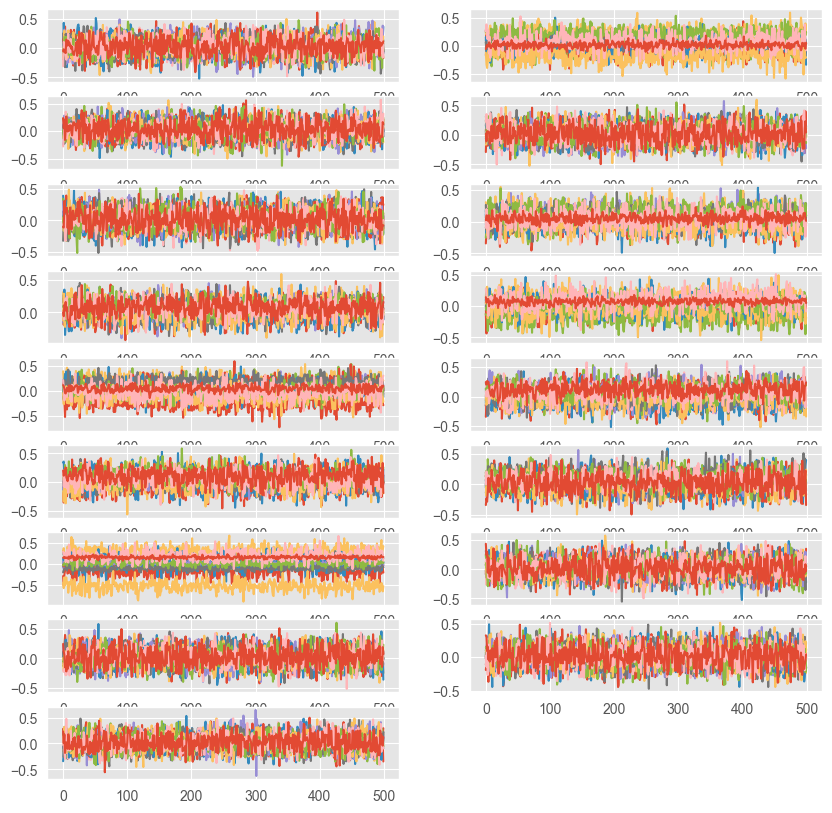

In [36]:
plt.rcParams['figure.figsize'] = (10, 10)

for i in range(17): #Looking at traceplot for beta parameters [Change the second index to switch between developed/developing]
    plt.subplot(9,2,i+1)
    plt.plot(posterior_samples_twoLevel_AB["beta"][::2,1,i,:])

#### Plotting traceplots for alpha

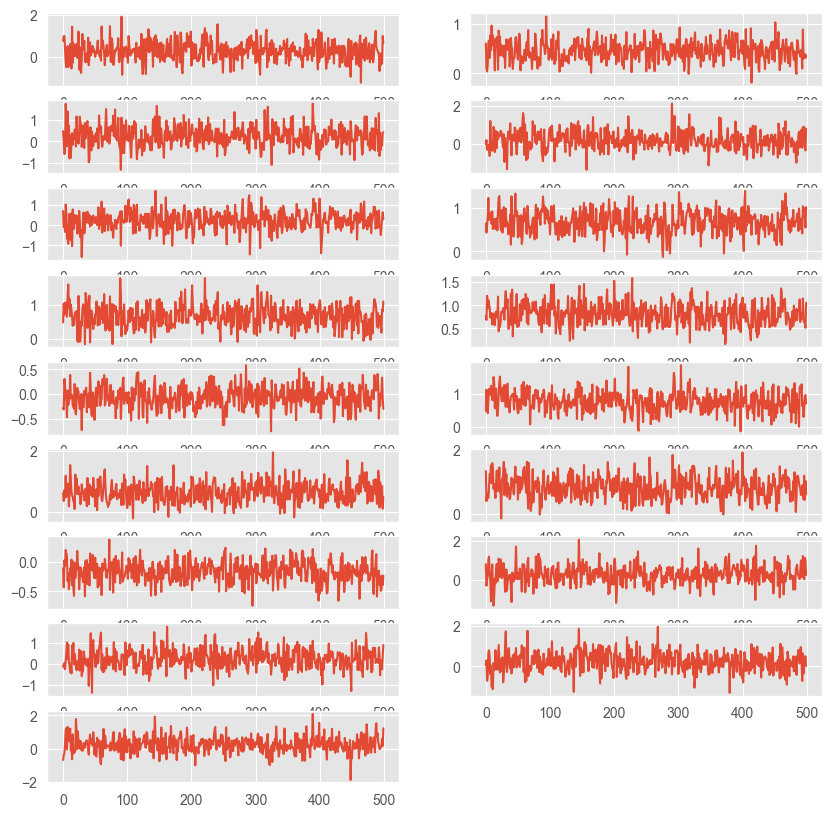

In [37]:
plt.rcParams['figure.figsize'] = (10, 10)

for i in range(17): #Looking at traceplot for alpha parameters [Change the second index to switch between developed/developing]
    plt.subplot(9,2,i+1)
    plt.plot(posterior_samples_twoLevel_AB["alpha"][::2,1,i])

#### Looking into the autocorrelation to validate thinning

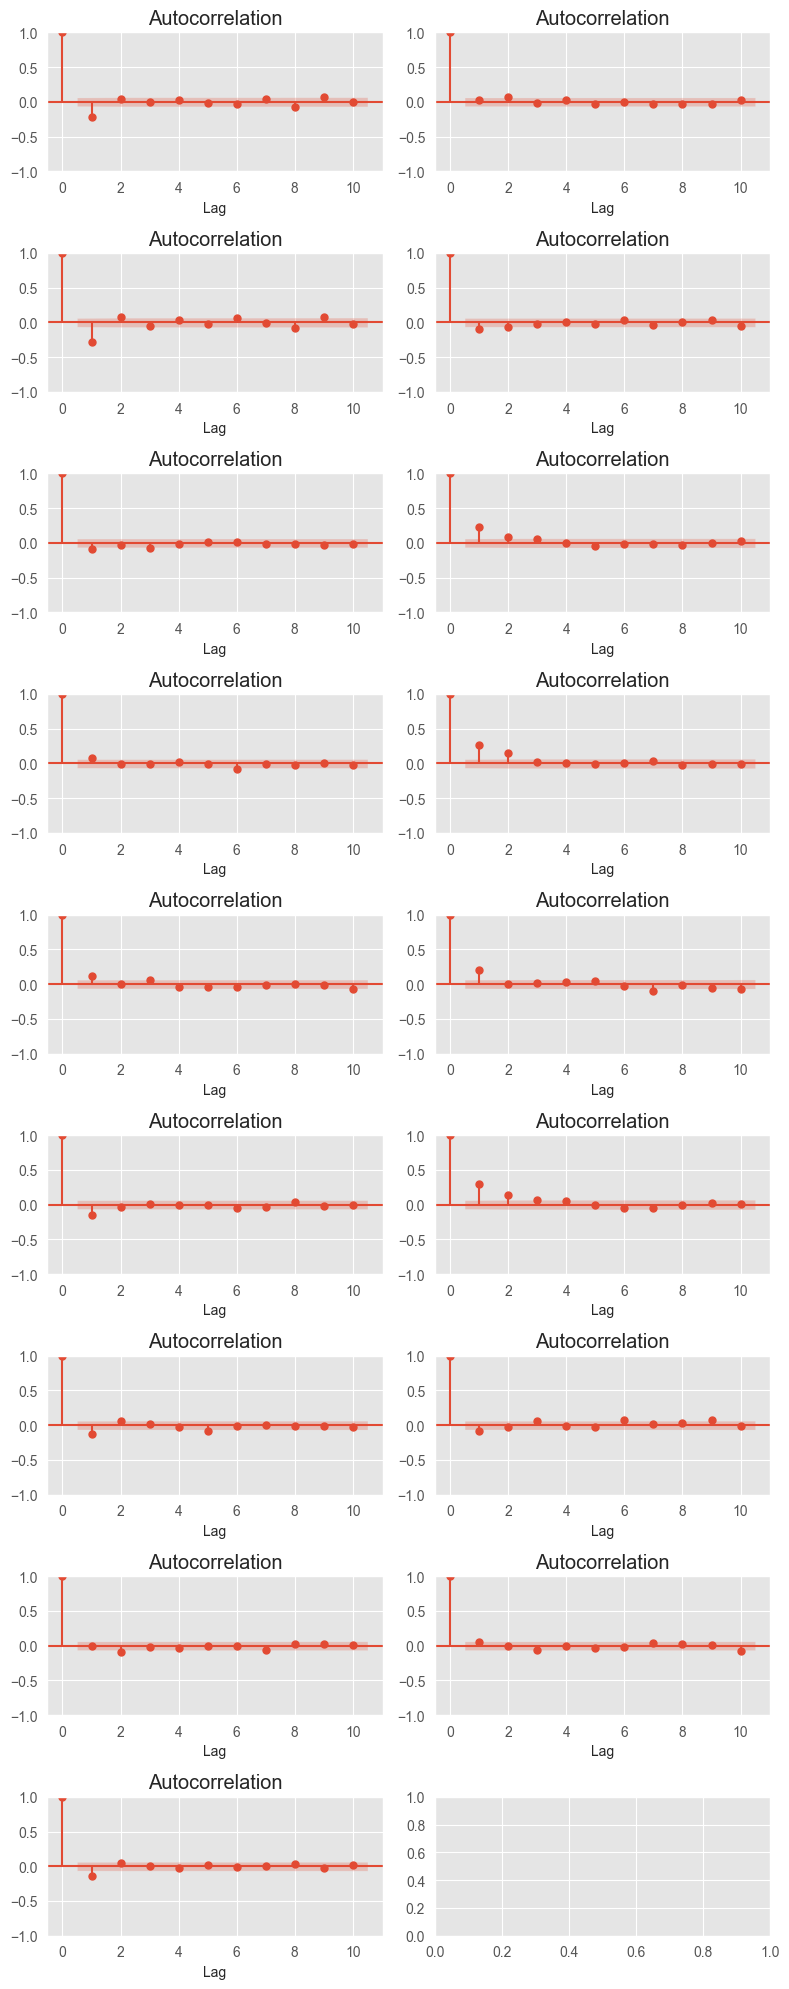

In [38]:
#Looking a autocorrelation without thinning
fig, axs = plt.subplots(9,2, figsize=(8, 20))

# Iterate over data and create ACF plots in subplots
for i in range(17):    
    row = i // 2; col = i % 2
    
    ax = axs[row, col]
    sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][:,1,i,1], ax=ax, lags=10) #Plot ACF
    ax.set_xlabel("Lag")

plt.tight_layout()

# Display the plot
plt.show()


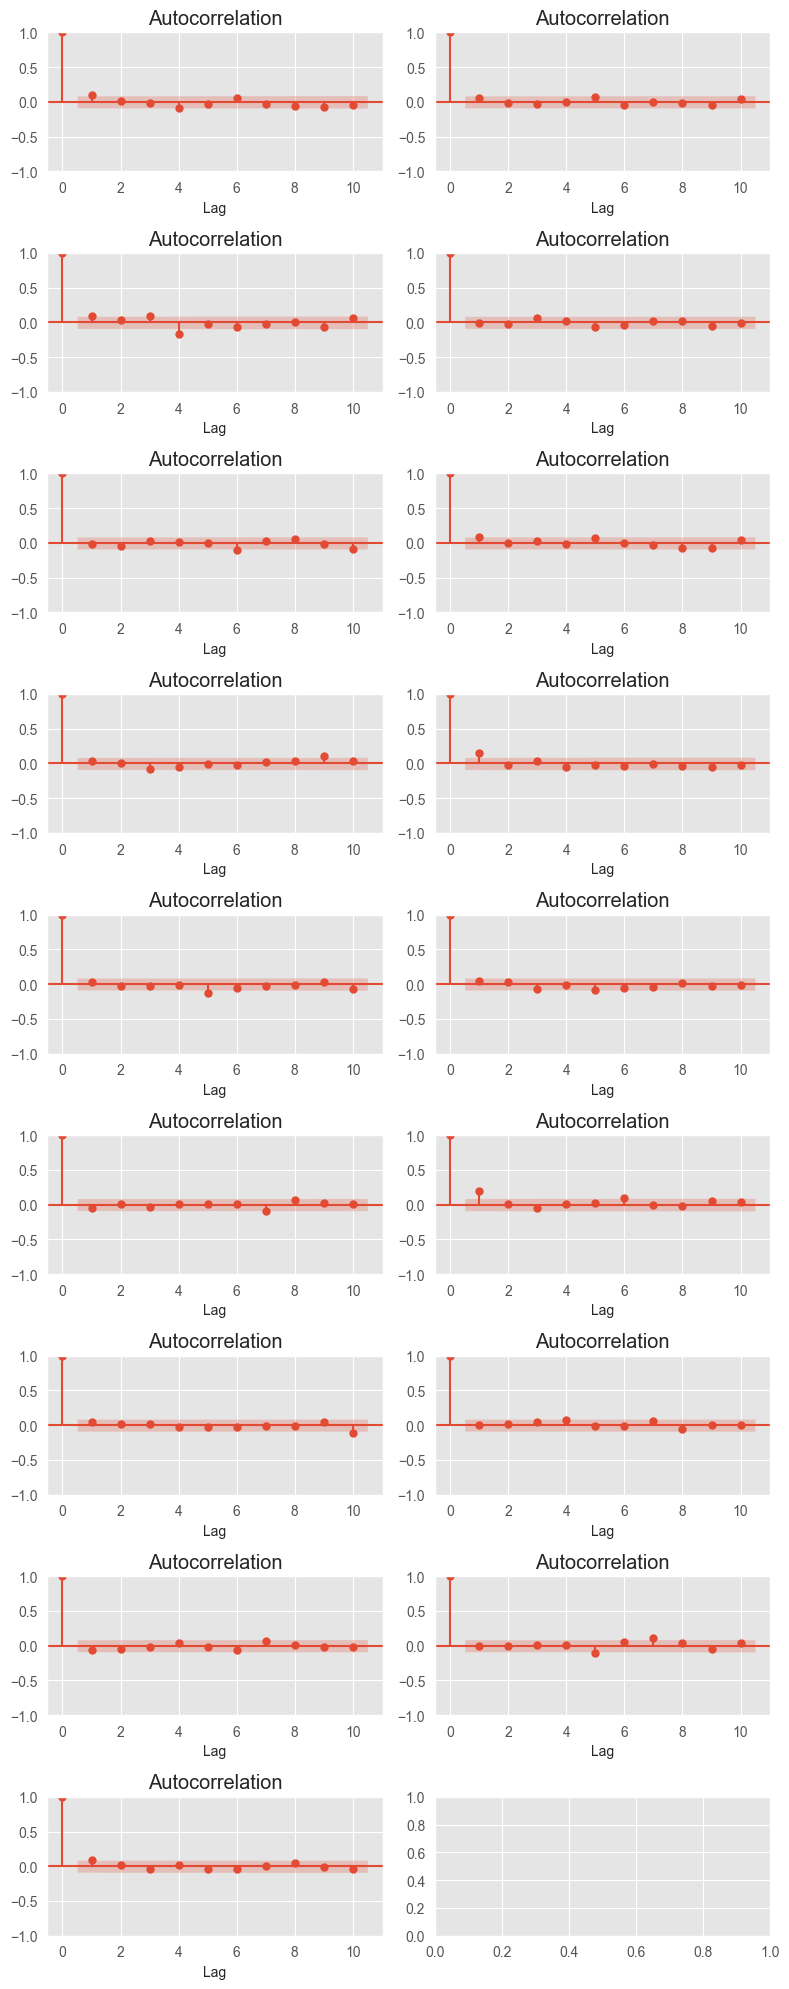

In [39]:
#Looking a autocorrelation with thinning
fig, axs = plt.subplots(9,2, figsize=(8, 20))

# Iterate over data and create ACF plots in subplots
for i in range(17):
    row = i // 2; col = i % 2
    
    ax = axs[row, col]
    sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][::2,1,i,1], ax=ax, lags=10) #Plot ACF
    ax.set_xlabel("Lag")

plt.tight_layout()

# Display the plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


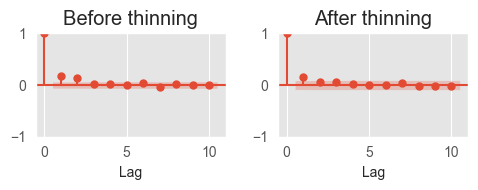

In [50]:
rand1 = random.randint(0, 1)  #Get random parameter to shown in the report. 
rand2 = random.randint(0, 16)
rand3 = random.randint(0, 14)

fig, axs = plt.subplots(1,2, figsize=(5, 2))  #Define figure 

ax = axs[0] #Without thinning
sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][:,rand1,rand2,rand3], ax=ax, lags=10) #Plot ACF
ax.set_xlabel("Lag")
ax.set_title("Before thinning")

ax = axs[1] #With thinning
sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][::2,rand1,rand2,rand3], ax=ax, lags=10) #Plot ACF
ax.set_xlabel("Lag")
ax.set_title("After thinning")

fig.tight_layout()
fig.show()

fig.savefig('ACF_plot.eps',format='eps',transparent=True)

In [51]:
#Calculating RMSE 
beta_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["beta"][::2], axis=0)
alpha_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["alpha"][::2], axis=0)

def ErrorTestFun_Model4(X_values,cont_idx,dev_idx,y_values):   #Define function to evaluate estimed parameters of the model
    
    multi_row = np.multiply(X_values,beta_hat_TwoLevel_AB[dev_idx,cont_idx,:])  #Perform linear algebra 
    beta_part = torch.sum(multi_row,dim=1)

    y_hat = alpha_hat_TwoLevel_AB[dev_idx,cont_idx] + beta_part
    
    preds = y_hat.numpy() * y_std + y_mean        #Convert back to original domain
    y_true = y_values * y_std + y_mean

    rmse = np.sqrt(np.mean((preds - y_true)**2))  #Calculate RMSE
    
    return rmse
    
rmse_train = ErrorTestFun_Model4(X_train, subregion_train,developed_train_pyro, y_train)
rmse_test  = ErrorTestFun_Model4(X_test, subregion_test, developed_test_pyro, y_test)
rmse_val   = ErrorTestFun_Model4(X_val, subregion_val, developed_val_pyro,  y_val)

print("RMSE train: %.3f \nRMSE test: %.3f \nRMSE val: %.3f" % (rmse_train,rmse_test,rmse_val))

RMSE train: 1.886 
RMSE test: 2.365 
RMSE val: 2.291


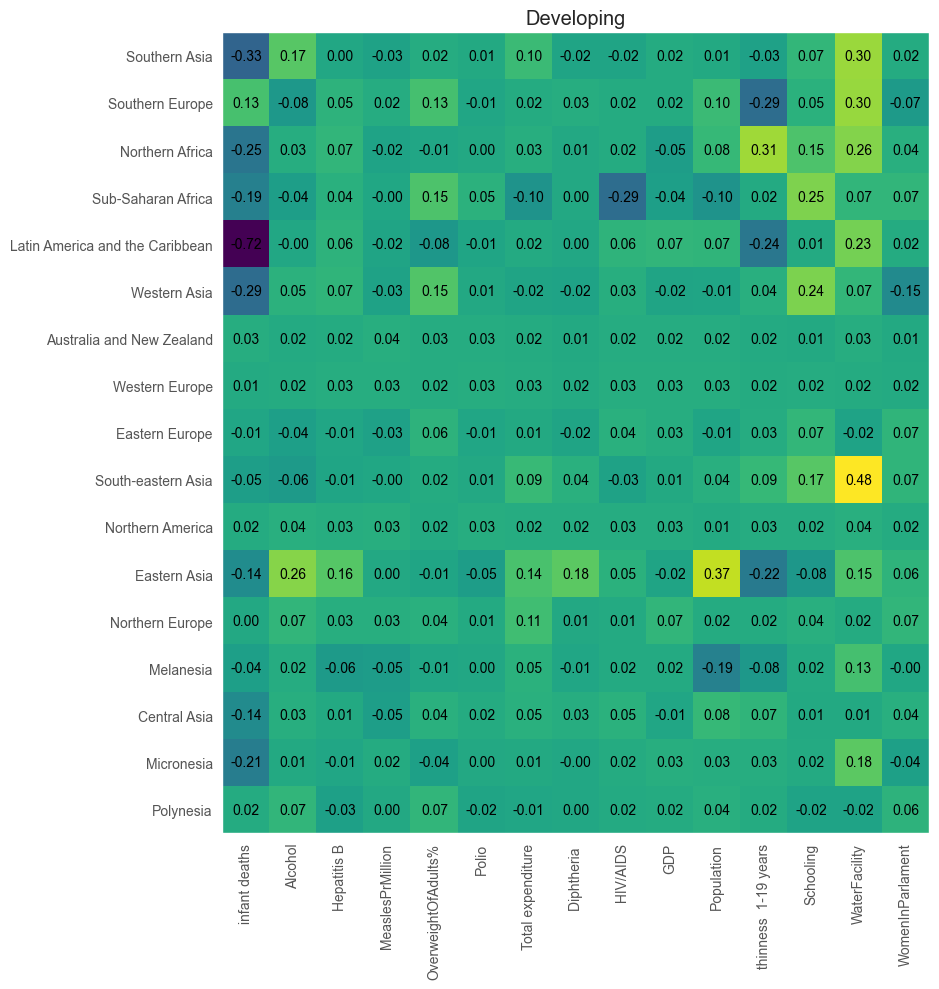

In [52]:
#Plotting Beta parameters for the Developing grouping 
list_labels = LED.columns.tolist()
num_betavalues = 15

heatMap_Beta_0 = beta_hat_TwoLevel_AB[0, :, :].numpy()

plt.imshow(heatMap_Beta_0,cmap='viridis') #Plot the values in a heatmap
plt.grid(visible=False)
plt.xticks(range(num_betavalues), list_labels[6:], rotation=90)
plt.yticks(list(subregion_dict.values()),list(subregion_dict.keys()))
plt.title("Developing")

for i in range(heatMap_Beta_0.shape[0]): #Add the number in the heatmap
    for j in range(heatMap_Beta_0.shape[1]):
        plt.text(j, i, f'{heatMap_Beta_0[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig("BetaMatrixDev0.eps",format="eps")

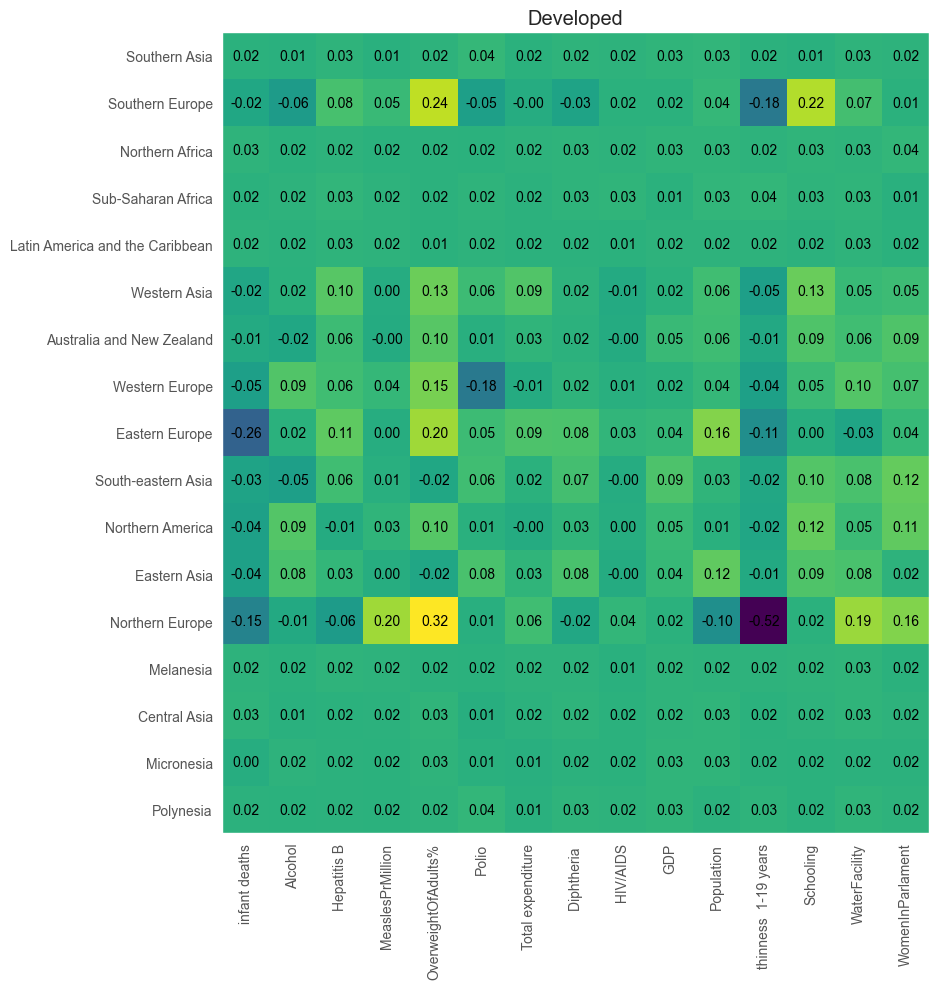

In [53]:
#Plotting Beta parameters for the Developed grouping 
heatMap_Beta_1 = beta_hat_TwoLevel_AB[1, :, :].numpy()

plt.imshow(heatMap_Beta_1,cmap='viridis') #Plot the values in a heatmap
plt.grid(visible=False)
plt.xticks(range(num_betavalues), list_labels[6:], rotation=90)
plt.yticks(list(subregion_dict.values()),list(subregion_dict.keys()))
plt.title("Developed")

for i in range(heatMap_Beta_1.shape[0]): #Add the number in the heatmap
    for j in range(heatMap_Beta_1.shape[1]):
        plt.text(j, i, f'{heatMap_Beta_1[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig("BetaMatrixDev1.eps",format="eps")

In [54]:
#Calculating to 90%CI for each of the alpha parameters
ci_lower_dev1 = np.array([])
ci_upper_dev1 = np.array([])

for i in range(17): #For developed sub-regions
    ci_lower_dev1 = np.append(ci_lower_dev1, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,1,i], (100 - 90) / 2))
    ci_upper_dev1 = np.append(ci_upper_dev1, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,1,i], 100 - (100 - 90) / 2))
    
ci_lower_dev0 = np.array([])
ci_upper_dev0 = np.array([])

for i in range(17): #For developing sub-regions
    ci_lower_dev0 = np.append(ci_lower_dev0, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,0,i], (100 - 90) / 2))
    ci_upper_dev0 = np.append(ci_upper_dev0, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,0,i], 100 - (100 - 90) / 2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


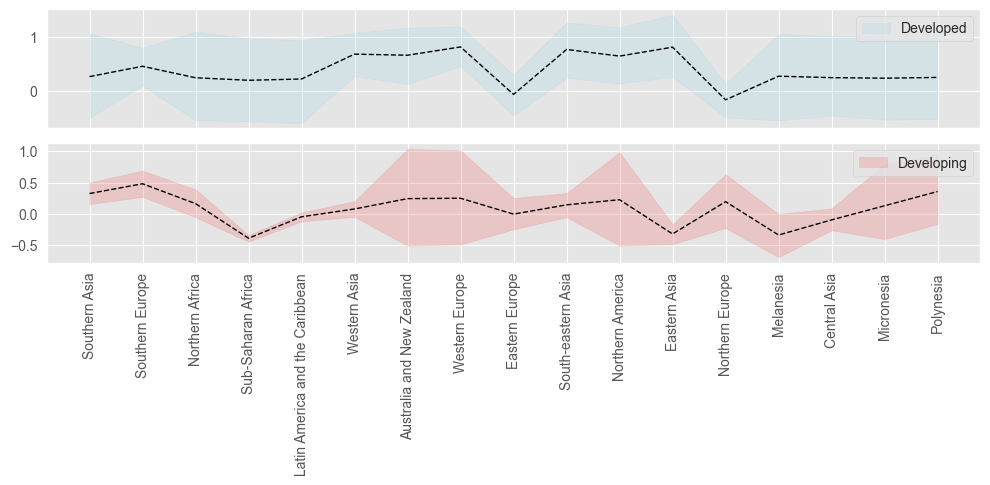

In [55]:
#Plot the alpha parameter estimates with a 90% CI 
plt.figure(figsize=(10, 5))

plt.subplot(2,1,1) #Alpha parameters for developed sub-regions 
plt.fill_between(list(subregion_dict.values()),ci_lower_dev1,ci_upper_dev1,alpha=0.3,label="Developed",color="lightblue")
plt.plot(alpha_hat_TwoLevel_AB[1, :],linestyle="--",color="black",linewidth=1.0)
plt.xticks(np.arange(17))
plt.tick_params(axis='x', labelbottom=False)
plt.legend()

plt.subplot(2,1,2) #Alpha parameters for developing sub-regions 
plt.fill_between(list(subregion_dict.values()),ci_lower_dev0,ci_upper_dev0,alpha=0.3,label="Developing",color="lightcoral")
plt.plot(alpha_hat_TwoLevel_AB[0, :],linestyle="--",color="black",linewidth=1.0)
plt.xticks(list(subregion_dict.values()), list(subregion_dict.keys()))
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()

plt.savefig('alpha_par_res.eps',format='eps')
plt.show()

.

.

## Temporal analysis of the data

This section contains the code for the temporal modelling of the data. It is split into 3 parts:
The first part has imports and data preparation. The second part defines the model and runs it and the third part evaluates it.

### Imports and data preparation

In [56]:
# The necessary libraries are imported and the random generator seed is fixed.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import time

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [57]:
# read data and take difference from year to year to introduce temporal aspect.


data = pd.read_csv("Data/Data_processed.csv", sep=';')


for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # transform data to look at differences from year to year for all nummerical features (2 first columns are country and continent)
    d.iloc[:,5:] = d.iloc[:,5:].diff()
    # replace invividual nan values with 0
    data[data['Country'] == country] = d

# for life expectancy we don't want to replace the old column as we will use it to calculate the difference for 1,2 and 3 years.
# So instead we define a new column and replace the old one at the end.

data['Life expectancy difference'] = 0
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy '].diff()


    # replace old values with new values
    data[data['Country'] == country] = d


In [58]:
# We add two new columns for the difference in life expectancy for 1 and 2 years ago. 
# We shift the life expectancy difference column
# such that we always predict one year ahead. 
# So for a difference in a variable from 2000 to 2001 we predict the difference in 2001 to 2002.

data['Life expectancy difference 1 year ago'] = 0
data['Life expectancy difference 2 years ago'] = 0
# get difference in life expectancy for each country and year
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy difference'].shift(-1)
    d['Life expectancy difference 1 year ago'] = d['Life expectancy difference'].shift(1)
    d['Life expectancy difference 2 years ago'] = d['Life expectancy difference'].shift(2)

    # replace old values with new values
    data[data['Country'] == country] = d

# drop nan as the year 2015 (most recent year) has no difference in life expectancy, as 2016 is not in the data to compare.
data = data.dropna()

In [59]:
# Make train and test split. The validation split is implicit in the test_split,
# as we will just use the last 2 years from test data as validation data.
# The reason for this is that the last two values of each split has to be given to the model as input, 
# (since we model it as dependent on the last two years).

train_split = data[data['Year'] < 2009]
test_split = data[data['Year'] >= 2009]

# make list of all columns that need to be standardized
cols = train_split.columns
# standardize all columns except country, continent, year and status (which are categorical and not used in the model)
for col in cols:
    if col not in ['Country', 'continent', 'Year', 'Status']:
        mean = train_split[col].mean()
        std = train_split[col].std()
        train_split[col] = (train_split[col] - mean) / std
        test_split[col] = (test_split[col] - mean) / std

# make numpy array of standardized data, first dimension is time, second is countries, third is features
# This prepares the data for the model.
countries_train = train_split['Country'].unique()
years_train = train_split['Year'].unique()
countries_test = test_split['Country'].unique()
years_test = test_split['Year'].unique()
cols = cols.drop(['Life expectancy ', 'Country', 'Year', 'continent', 'Life expectancy difference 1 year ago', 'Life expectancy difference 2 years ago', 'Life expectancy difference'])
train_split_np_features = np.empty((len(years_train), len(countries_train), len(cols)))
train_split_np_target = np.empty((len(years_train), len(countries_train)))
test_split_np_features = np.empty((len(years_test), len(countries_test), len(cols)))
test_split_np_target = np.empty((len(years_test), len(countries_test)))
target = 'Life expectancy difference'

# Here we fill in the values for the train and test split, both target and features.
for i, country in enumerate(countries_train):
    for j, year in enumerate(years_train):
        # take nummeric data of country and put in numpy array
        train_split_np_features[j, i] = train_split.loc[(train_split['Country'] == country) & (train_split['Year'] == year)][cols].to_numpy()
        # take target of country and put in numpy array
        train_split_np_target[j, i] = train_split.loc[(train_split['Country'] == country) & (train_split['Year'] == year)][target].to_numpy()
for i, country in enumerate(countries_test):
    for j, year in enumerate(years_test):
        # take nummeric data of country and put in numpy array
        test_split_np_features[j, i] = test_split.loc[(test_split['Country'] == country) & (test_split['Year'] == year)][cols].to_numpy()
        # take target of country and put in numpy array
        test_split_np_target[j, i] = test_split.loc[(test_split['Country'] == country) & (test_split['Year'] == year)][target].to_numpy()

# We add the last two years of the train split to the test split, as we need them as input for the model.
# Again, this is because we model the life expectancy difference as dependent on the last two years.
test_split_np_features = np.concatenate((train_split_np_features[-2:], test_split_np_features))
test_split_np_target = np.concatenate((train_split_np_target[-2:], test_split_np_target))


### Defining the model

First, we will be defining the model using numpyro. Here we use the jax backend for numpyro.

In [60]:
# We will now define the model

# This function is the carry function, which is used in the scan function, it models the time dependency to calculate the ht latent variable.

def f(carry, h_external_change):
    beta2, z_prev1, z_prev2 = carry
    z_t_normal = (beta2[0]*z_prev1 + beta2[1]*z_prev2 + h_external_change)
    z_t = z_t_normal
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta2, z_prev1, z_prev2), z_t

# Here we define the model. 
# For a more detailed explanation of the model, see the report (PGM or generative story)
def model(obs_x, obs_y):
    time = obs_x.shape[0]
    countries = obs_x.shape[1]
    features_x = obs_x.shape[2]
    dim_h = 2
    
    with numpyro.plate("weights", features_x):
        beta1 = numpyro.sample(name="beta1", fn=dist.Normal(loc=0., scale=1))
    with numpyro.plate("countries", countries):
        z0 = numpyro.sample(name="z0", fn=dist.Normal(loc=0, scale=.1))
        z1 = numpyro.sample(name="z1", fn=dist.Normal(loc=0, scale=.1))
    
    with numpyro.plate("time_x", features_x):
        with numpyro.plate("countries_x", countries):
            with numpyro.plate("features_x", time):
                xs = numpyro.sample(name="xs", fn=dist.Normal(loc=0., scale=1.), obs=obs_x)

    with numpyro.plate("weights2", 2):
        beta2 = numpyro.sample(name="beta2", fn=dist.Normal(loc=0., scale=1))

    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))

    with numpyro.plate("countries", countries):
        with numpyro.plate("time", time):
            h_external_change = numpyro.sample(name="h_change", fn=dist.Normal(loc=xs @ beta1, scale=tau))

    carry = (beta2, z0, z1)
    z_collection = [z0, z1]
    carry, zs_exp = lax.scan(f, carry, h_external_change, time)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    with numpyro.plate("countries", countries):
        with numpyro.plate("time", time):
            numpyro.sample(name="y_obs", fn=dist.Normal(loc=zs_exp, scale=sigma), obs=obs_y)
    return z_collection


In [61]:

# We will now run the model
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1, progress_bar=True)
mcmc.run(rng_key_, obs_x=train_split_np_features, obs_y=train_split_np_target)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [00:34<00:00, 58.52it/s, 255 steps of size 5.00e-03. acc. prob=1.00]


Total time: 0.663m


### Evaluating the model

We will both be printing some values of the beta parameters and looking at the performance.
The beta1 has all the coeffici of the differential features effect on the h_{t} latent variable, while beta2 holds the coefficients of the h_{t-1} and h_{t-2} latent variables on the h_{t} latent variable.

In [62]:
# Print some statistics for the beta's
beta1 = mcmc.get_samples()['beta1'].mean(0)
beta2 = mcmc.get_samples()['beta2'].mean(0)
print(beta1)
print(beta2)


[ 7.0166595e-02 -1.8294312e-01  7.7119460e-03  2.1047480e-04
 -1.9920954e-02  2.7549623e-02  8.2173347e-03  1.0607784e-02
 -3.6333199e-04 -2.1152161e-01  3.1199126e-02  6.1083712e-02
  3.3958375e-02 -2.5482597e-02  7.0272081e-02 -1.2428053e-02]
[-0.13790154  0.13728343]


In [63]:
# Here we calculate the test split for the model and the baseline
errors = []
errors_baseline = []
# the reason for looping from 2 to 6 is because we need the last two years of the train split as input for the model
for i in range(2, 6):
    # Predictions are simply made by using the mean values of the beta's (see report for more details)
    prediction = beta2[0] * test_split_np_target[i-1] + beta2[1] * test_split_np_target[i-2] + test_split_np_features[i] @ beta1
    errors.append(np.mean(((prediction - test_split_np_target[i])*std)**2))
    errors_baseline.append(np.mean((test_split_np_target[i]*std)**2))
print("RMSE for model on test_split: " + str(np.sqrt(np.mean(errors))))
print("RMSE for baseline on test_split: " + str(np.sqrt(np.mean(errors_baseline))))
 

RMSE for model on test_split: 0.52887076
RMSE for baseline on test_split: 0.543183710823336


In [64]:
#Very much the same as before, but in this case for the validation split

errors = []
errors_baseline = []
# we loop from 4 to 8 here, so we include the last 2 values of the test split as input for the model
for i in range(4, 8):
    prediction = beta2[0] * test_split_np_target[i-1] + beta2[1] * test_split_np_target[i-2] + test_split_np_features[i] @ beta1
    errors.append(np.mean(((prediction - test_split_np_target[i])*std)**2))
    errors_baseline.append(np.mean((test_split_np_target[i]*std)**2))
print("RMSE for model on validation_split: " + str(np.sqrt(np.mean(errors))))
print("RMSE for baseline on validation_split: " + str(np.sqrt(np.mean(errors_baseline))))

RMSE for model on validation_split: 0.9060316
RMSE for baseline on validation_split: 0.9252065056485308


In [65]:
# And finally, for the train split
errors = []
errors_baseline = []
# Here we loop from 0 to 7, as we have no values before the train split to use as input for the model
for i in range(7):
    prediction = beta2[0] * train_split_np_target[i-1] + beta2[1] * train_split_np_target[i-2] + train_split_np_features[i] @ beta1
    errors.append(np.mean(((prediction - train_split_np_target[i])*std)**2))
    errors_baseline.append(np.mean((train_split_np_target[i]*std)**2))
print("RMSE for model on train_split: " + str(np.sqrt(np.mean(errors))))
print("RMSE for baseline on train_split: " + str(np.sqrt(np.mean(errors_baseline))))


RMSE for model on train_split: 0.51673096
RMSE for baseline on train_split: 0.5494875377015397


In [66]:
# and finally, we print the summary of the model

mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1[0]      0.07      0.07      0.07     -0.04      0.18     97.18      1.01
       beta1[1]     -0.18      0.03     -0.18     -0.24     -0.13     29.94      1.01
       beta1[2]      0.01      0.03      0.01     -0.04      0.05     90.99      1.02
       beta1[3]      0.00      0.03      0.00     -0.05      0.05     42.91      1.05
       beta1[4]     -0.02      0.03     -0.02     -0.07      0.02     87.92      1.00
       beta1[5]      0.03      0.03      0.03     -0.02      0.07    113.50      1.00
       beta1[6]      0.01      0.03      0.01     -0.03      0.05    115.88      1.01
       beta1[7]      0.01      0.03      0.01     -0.03      0.05    173.62      1.00
       beta1[8]     -0.00      0.03     -0.00     -0.04      0.04     77.89      1.04
       beta1[9]     -0.21      0.03     -0.21     -0.26     -0.17     89.46      1.00
      beta1[10]      0.03      0.03      0.03     -0.